# IRAN COVID-19 DATA ANALYSIS

In [1]:
import os
import pandas as pd
import requests
import csv
from io import StringIO
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import scipy.stats as stats
import pylab
import scipy.stats as stats

In [2]:
!pip install request

In [3]:
!pip install requests

In [4]:
d = requests.get("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv");
d.text
k = StringIO(d.text)
df1 = pd.read_csv(k)
df1.rename(columns={'Country/Region':'Country'}, inplace=True)
df1=df1.query('Country == "Iran"')
df1.rename(index={133:'Total_Patients_Died'}, inplace=True)

In [5]:
c = requests.get("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv");
c.text
c.text.replace("/","",100)
f = StringIO(c.text)
df2 = pd.read_csv(f) 
df2.rename(columns={'Country/Region':'Country'}, inplace=True)
df2=df2.query('Country == "Iran"')
df2.rename(index={133:'Total_Cases'}, inplace=True)

In [6]:
r = requests.get("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv");
r.text
r.text.replace("/","",100)
m = StringIO(r.text)
df3 = pd.read_csv(m)
df3.rename(columns={'Country/Region':'Country'}, inplace=True)
df3=df3.query('Country == "Iran"')
df3.rename(index={127:'Total_Patients_Treated'}, inplace=True)

In [7]:
df = pd.concat([df2, df1, df3])
df = df.dropna(how='all')
df.drop('Province/State', axis=1, inplace=True)
df.drop('Lat', axis=1, inplace=True)
df.drop('Long', axis=1, inplace=True)
df.drop('Country', axis=1, inplace=True)

In [8]:
dff=df.transpose()
tff=dff.loc[~(dff==0).all(axis=1)]
tff.index.name='Date'
tff.head()    #Total Cases

,Total_Cases,Total_Patients_Died,Total_Patients_Treated
Date,,,
2/19/20,2,2,0
2/20/20,5,2,0
2/21/20,18,4,0
2/22/20,28,5,0
2/23/20,43,8,0


In [9]:
import numpy as np
a1=np.zeros(((len(dff.index)),3))

In [10]:
for i in range(1,(len(dff.index))):
    a1[i,0]=dff.iloc[i,0]-dff.iloc[i-1,0]       
    a1[i,1]=dff.iloc[i,1]-dff.iloc[i-1,1]
    a1[i,2]=dff.iloc[i,2]-dff.iloc[i-1,2]

In [11]:
trr = pd.DataFrame(a1.astype(int), columns=("Daily_Cases","Daily_Patients_Died","Daily_Patients_Treated"), index=dff.index)
iran = trr.loc[~(trr==0).all(axis=1)]
iran.index.name='Date'

In [12]:
iran[iran < 0] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [14]:
iran.index = pd.to_datetime(iran.index)
tff.index = pd.to_datetime(tff.index)

## Data Analysis After First Death

When we look at the COVID-19 propagation process in general terms, we see that the distribution increases as exponential function.
However, not all cases can be detected, since countries cannot test enough when the virus first appeared.
For this reason, the distribution of data in the first days does not fit the general averages.
For example, we have seen that the mortality rate of the virus in Iran is 100%, then 20-40%.
On the other hand, that was around 2.5% in China.
Therefore, in this study, the analysis was made over the dates after the first case death, where the data began to approach the reality more than the first case.

In [18]:
tff["Death_Rate"] = tff["Total_Patients_Died"] / tff["Total_Cases"]

In [19]:
for i in range(0,len(tff.index)):
    if tff["Total_Patients_Died"][i] > 0:
        tff = tff.iloc[i:,::] 
        break
    else:
        continue

In [20]:
for i in range(0,len(iran.index)):
    if iran["Daily_Patients_Died"][i] > 0:
        iran = iran.iloc[i:,::] 
        break
    else:
        continue

### Outliers Analysis

In [21]:
lof = LocalOutlierFactor(n_neighbors=20 , contamination=0.1)

In [22]:
lof.fit_predict(iran)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1])

In [23]:
lof_scores=lof.negative_outlier_factor_

In [24]:
np.sort(lof_scores)

array([-4.51047996, -2.66360943, -1.62728189, -1.57157829, -1.55448807,
       -1.50872336, -1.49862395, -1.49036038, -1.44722145, -1.44131109,
       -1.39356898, -1.39009979, -1.36397698, -1.34854295, -1.33259675,
       -1.30351902, -1.19450125, -1.19231832, -1.12292599, -1.0976862 ,
       -1.08626917, -1.08151298, -1.07916291, -1.06842329, -1.06805133,
       -1.06517182, -1.06420342, -1.06392851, -1.06344817, -1.06273382,
       -1.06043399, -1.05898846, -1.05338768, -1.04222012, -1.03710856,
       -1.03411983, -1.02964307, -1.0237556 , -1.02167696, -1.01937255,
       -1.01754506, -0.99756863, -0.99753409, -0.99655049, -0.996503  ,
       -0.99425494, -0.99200058, -0.99189703, -0.99058282, -0.99041802,
       -0.99000805, -0.98983688, -0.98893748, -0.98721023, -0.98433784,
       -0.98195342, -0.97816522, -0.97785841, -0.97768461, -0.97723656,
       -0.97720625, -0.97642455, -0.97626158, -0.9750201 , -0.97409092,
       -0.97304987, -0.97107174, -0.96970388, -0.96582847, -0.96

In [25]:
threshold_value = np.sort(lof_scores)[3]

In [26]:
iran[lof_scores < threshold_value]

,Daily_Cases,Daily_Patients_Died,Daily_Patients_Treated
Date,,,
2020-04-06,2274,136,4500
2020-04-10,1972,122,3156
2020-04-11,1837,125,6482


The values listed above do not match the overall outbreak averages.
According to my calculations, these values can be considered as outliers.

### Probability Plot

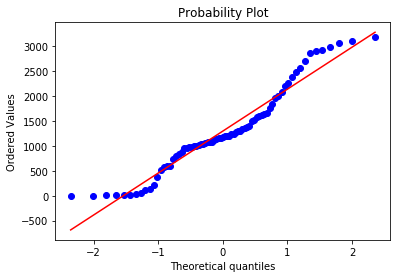

In [27]:
stats.probplot(iran["Daily_Cases"] , dist="norm", plot=pylab)
pylab.show()

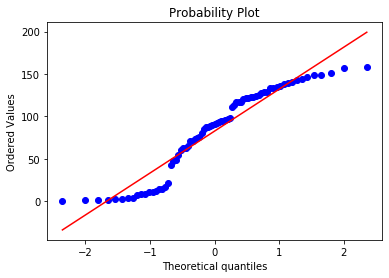

In [28]:
stats.probplot(iran["Daily_Patients_Died"] , dist="norm", plot=pylab)
pylab.show()

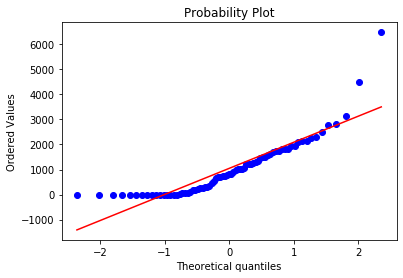

In [29]:
stats.probplot(iran["Daily_Patients_Treated"] , dist="norm", plot=pylab)
pylab.show()

### General Statistics of Data

In [30]:
iran.describe().T

,count,mean,std,min,25%,50%,75%,max
Daily_Cases,75.0,1298.986667,849.250822,2.0,858.0,1178.0,1645.5,3186.0
Daily_Patients_Died,75.0,82.706667,50.464270,0.0,45.0,91.0,124.5,158.0
Daily_Patients_Treated,75.0,1045.626667,1136.789300,0.0,51.0,817.0,1661.5,6482.0


## Data Visualization

### Variable Relationship Graphics

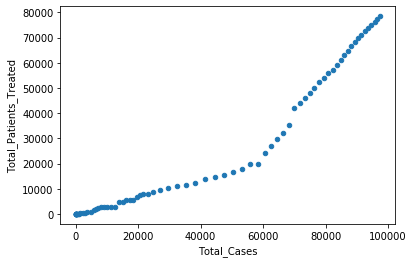

In [31]:
tff.plot.scatter("Total_Cases","Total_Patients_Treated");

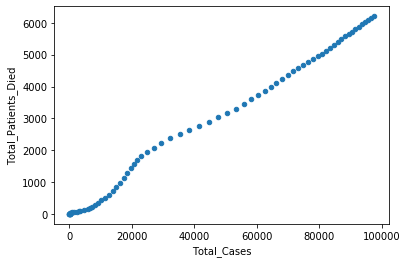

In [32]:
tff.plot.scatter("Total_Cases","Total_Patients_Died");

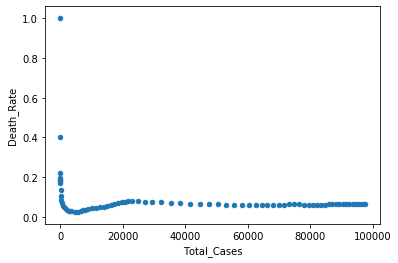

In [33]:
tff.plot.scatter("Total_Cases","Death_Rate");

### KDE Plots

The reason for taking the death rate value so wide is that it was very high in the first days.
However, a few days later this value became normal and began to concentrate around a value.

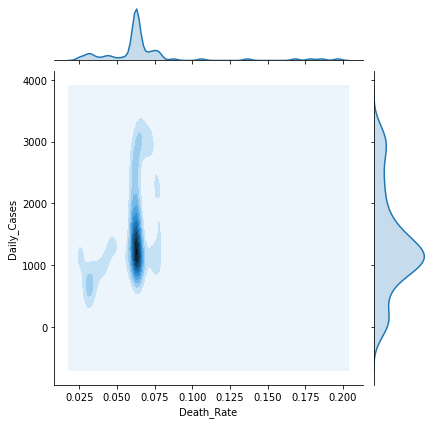

In [36]:
sns.jointplot(x=tff["Death_Rate"][3::], y=iran["Daily_Cases"][3::], data=iran,  kind="kde");

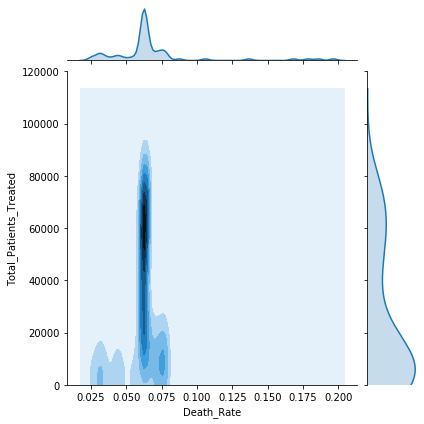

In [44]:
sns.jointplot(x=tff["Death_Rate"][3::], y=tff["Total_Patients_Treated"][3::] , data=tff, kind="kde" ,ylim=(0,120000));

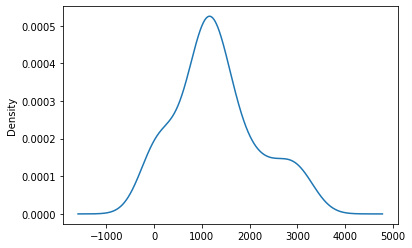

In [48]:
iran["Daily_Cases"].plot.kde();

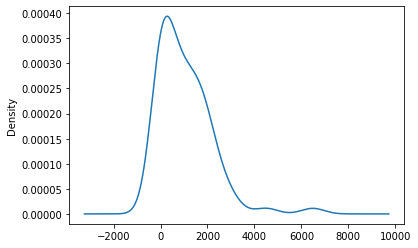

In [49]:
iran["Daily_Patients_Treated"].plot.kde();

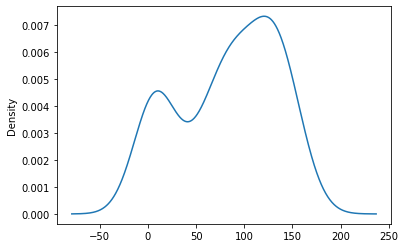

In [50]:
iran["Daily_Patients_Died"].plot.kde();

### Time Dependent Graphs

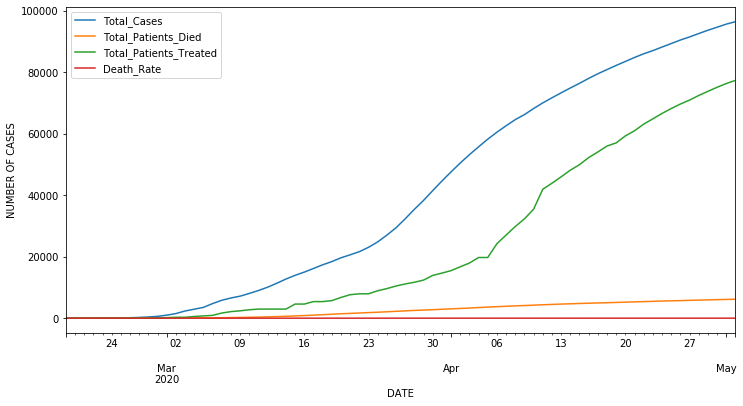

In [51]:
gra=tff.plot(figsize=(12,6))
gra.set_xlabel("DATE")
gra.set_ylabel("NUMBER OF CASES");

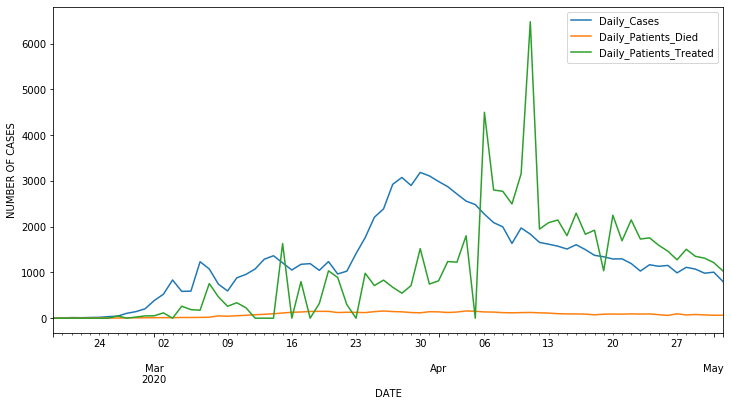

In [52]:
gra=iran.plot(figsize=(12,6))
gra.set_xlabel("DATE")
gra.set_ylabel("NUMBER OF CASES");